<a href="https://colab.research.google.com/github/diliprc96/POS_Tagging/blob/main/POS_Tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/drive/MyDrive/POS_Tagging/DATASET_POS.zip
!unzip /content/drive/MyDrive/POS_Tagging/glove.6B.100d.txt.zip

Archive:  /content/drive/MyDrive/POS_Tagging/DATASET_POS.zip
  inflating: Dataset_POS/WSJ_test.pos  
  inflating: Dataset_POS/WSJ_train.pos  
Archive:  /content/drive/MyDrive/POS_Tagging/glove.6B.100d.txt.zip
  inflating: glove.6B.100d.txt       


In [2]:
# Importing Libraries
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Bidirectional
from transformers import BertTokenizer, TFBertModel
import importlib.util
from tensorflow.keras.callbacks import EarlyStopping

# Check Import Modules
def check_import(module_name):
    if importlib.util.find_spec(module_name) is not None:
        print(f"{module_name} ✅ Imported Successfully")
    else:
        print(f"{module_name} ❌ Not Installed")

modules = ['os', 'numpy', 'pandas', 'matplotlib', 'sklearn', 'tensorflow', 'transformers']
for module in modules:
    check_import(module)

os ✅ Imported Successfully
numpy ✅ Imported Successfully
pandas ✅ Imported Successfully
matplotlib ✅ Imported Successfully
sklearn ✅ Imported Successfully
tensorflow ✅ Imported Successfully
transformers ✅ Imported Successfully


In [3]:
# Load Dataset
def load_data(file_path):
    if not os.path.exists(file_path):
        print(f"File Not Found: {file_path}")
        return None
    sentences, sentence = [], []
    for line in open(file_path, 'r'):
        line = line.strip()
        if line == "":
            if sentence:
                sentences.append(sentence)
                sentence = []
        else:
            try:
                word, tag = line.split()
                sentence.append((word, tag))
            except ValueError:
                continue
    if sentence:
        sentences.append(sentence)
    return sentences

# Dataset Path
dataset_folder = "/content/Dataset_POS"

train_data = load_data(os.path.join(dataset_folder, 'WSJ_train.pos'))
test_data = load_data(os.path.join(dataset_folder, 'WSJ_test.pos'))

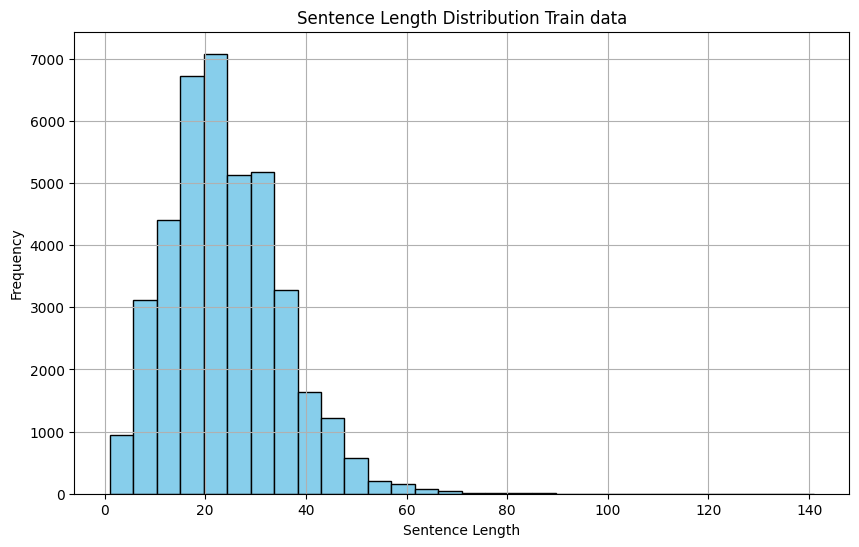

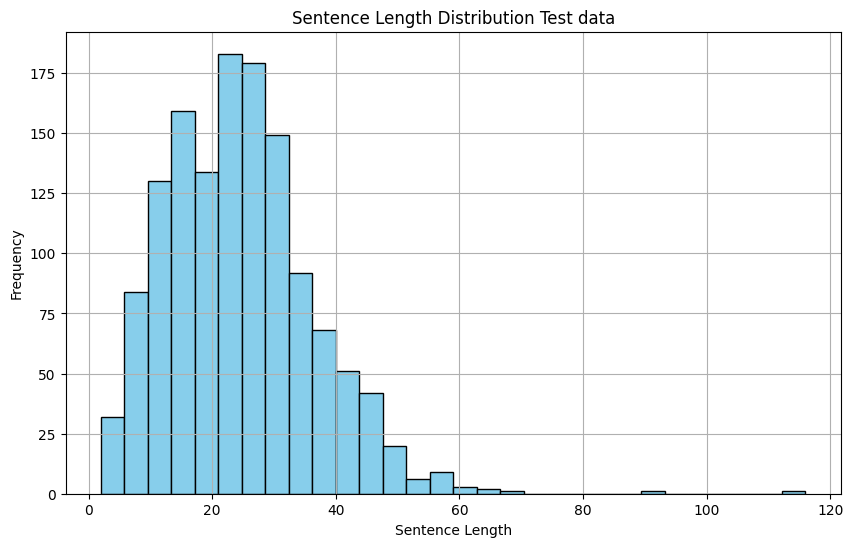

In [4]:
# Sentence Length Distribution
sentence_lengths = [len(sentence) for sentence in train_data]
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution Train data')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

sentence_lengths = [len(sentence) for sentence in test_data]
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Sentence Length Distribution Test data')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
# Build Vocabulary
word_counts = defaultdict(int)
tags = set()
for sentence in train_data:
    for word, tag in sentence:
        word_counts[word.lower()] += 1
        tags.add(tag)

vocab = {word: idx + 1 for idx, word in enumerate(word_counts.keys())}
vocab['<PAD>'] = 0
index_to_word = {idx: word for word, idx in vocab.items()}

tag_to_index = {tag: idx + 1 for idx, tag in enumerate(sorted(tags))}
tag_to_index['O'] = 0  # Default tag

# Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = max([len(sentence) for sentence in train_data])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
# Normalize text function
def normalize_text(text):
    """Normalizes text by lowercasing, handling numbers, and dates."""
    text = text.lower()  # Lowercase the text

    # Replace numbers with a special token
    text = re.sub(r'\d+', '<NUM>', text)

    # Replace dates with a special token
    # You can adjust the date format regex as needed
    text = re.sub(r'\d{2}/\d{2}/\d{4}', '<DATE>', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '<DATE>', text)

    # Handle other special tokens if needed (e.g., punctuation)
    # For example, punctuation marks can be tokenized as their own tokens
    text = re.sub(r'[^\w\s]', ' <PUNCT> ', text)

    return text

# Prepare data function that tokenizes using both BERT and GloVe
def prepare_data(sentences, vocab, tokenizer, max_len):
    X_bert, X_glove, y, attention_masks = [], [], [], []
    for sentence in sentences:
        words = [word for word, tag in sentence]
        tags = [tag_to_index[tag] for word, tag in sentence]

        # Normalize words before tokenization
        normalized_words = [normalize_text(word) for word in words]

        # BERT Tokenization
        tokens = tokenizer(normalized_words,
                           padding=True,
                           truncation=True,
                           max_length=max_len,
                           is_split_into_words=True,
                           return_attention_mask=True)
        X_bert.append(tokens['input_ids'])
        attention_masks.append(tokens['attention_mask'])

        # GloVe Tokenization (using vocab created from GloVe embeddings)
        X_glove.append([vocab.get(word.lower(), 1) for word in normalized_words])

        y.append(tags)

    # Padding sequences for both BERT and GloVe inputs and the tags
    X_bert = pad_sequences(X_bert, maxlen=max_len, padding='post', value=0)
    attention_masks = pad_sequences(attention_masks, maxlen=max_len, padding='post', value=0)
    X_glove = pad_sequences(X_glove, maxlen=max_len, padding='post', value=0)
    y = pad_sequences(y, maxlen=max_len, padding='post', value=0)

    return np.array(X_bert), np.array(X_glove), np.array(y), attention_masks

# Building Vocabulary for GloVe embeddings
word_counts = defaultdict(int)
tags = set()

# Collecting word frequencies and tag set from the training data
for sentence in train_data:
    for word, tag in sentence:
        word_counts[word.lower()] += 1
        tags.add(tag)

# Create vocab: maps each word to an index
vocab = {word: idx + 1 for idx, word in enumerate(word_counts.keys())}
vocab['<PAD>'] = 0  # Adding padding token
index_to_word = {idx: word for word, idx in vocab.items()}

# Create tag_to_index mapping for tags (used as target labels)
tag_to_index = {tag: idx + 1 for idx, tag in enumerate(sorted(tags))}
tag_to_index['O'] = 0  # Default tag for outside entities

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define MAX_LEN based on the length of the longest sentence in the train data
MAX_LEN = max([len(sentence) for sentence in train_data])

# Example: Now, prepare the data using the function
X_train_bert, X_train_glove, y_train, X_train_attention_mask = prepare_data(train_data, vocab, bert_tokenizer, MAX_LEN)
X_test_bert, X_test_glove, y_test, X_test_attention_mask = prepare_data(test_data, vocab, bert_tokenizer, MAX_LEN)

# Output shapes to verify
print("BERT Input Shape: ", X_train_bert.shape)
print("Attention Mask Shape: ", X_train_attention_mask.shape)
print("GloVe Input Shape: ", X_train_glove.shape)
print("Tag Output Shape: ", y_train.shape)


BERT Input Shape:  (39832, 141)
Attention Mask Shape:  (39832, 141)
GloVe Input Shape:  (39832, 141)
Tag Output Shape:  (39832, 141)


In [7]:
# Load GloVe Embeddings
def load_glove_embeddings(glove_path, vocab, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coeffs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coeffs

    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    for word, i in vocab.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

GLOVE_PATH = "/content/glove.6B.100d.txt"
embedding_matrix = load_glove_embeddings(GLOVE_PATH, vocab, embedding_dim=100)



In [24]:
# Build Models
def build_bert_model(max_len, num_tags):
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")


    # Get BERT output and specify output shape for the Lambda layer
    bert_output = tf.keras.layers.Lambda(
        lambda x: bert_model(x[0], attention_mask=x[1])[0], output_shape=(max_len, bert_model.config.hidden_size))([input_word_ids, input_attention_mask])

    lstm = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(bert_output)
    out = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm)
    model = tf.keras.Model(inputs=[input_word_ids, input_attention_mask], outputs=out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def build_glove_model(max_len, num_tags, embedding_matrix, embedding_dim=100):
    input_layer = tf.keras.layers.Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=len(vocab), output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
    lstm = Bidirectional(LSTM(units=100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedding_layer)
    out = TimeDistributed(Dense(num_tags, activation="softmax"))(lstm)
    model = tf.keras.Model(inputs=input_layer, outputs=out)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [25]:
# Create Models
model_bert = build_bert_model(MAX_LEN, len(tag_to_index))
model_glove = build_glove_model(MAX_LEN, len(tag_to_index), embedding_matrix)
model_bert.summary()
model_glove.summary()

# Define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Models
model_bert.fit([X_train_bert, X_train_attention_mask], y_train, batch_size=32, epochs=1, validation_split=0.2, callbacks=[early_stopping])
model_bert.save('/content/drive/MyDrive/POS_Tagging/model_bert_epoch_1.keras')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)    │ (None, 141)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 141)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 141, 768)       │              0 │ input_ids[0][0],       │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_8           │ (None, 141, 200)       │        695,200 │ lambda_4[0][0]         │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_8        │ (None, 141, 46)        │          9,246 │ bidirectional_8[0][0]  │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 704,446 (2.69 MB)

 Trainable params: 704,446 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 141)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 141, 100)            │       3,954,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 141, 200)            │         160,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 141, 46)             │           9,246 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,124,846 (15.74 MB)

 Trainable params: 170,046 (664.24 KB)

 Non-trainable params: 3,954,800 (15.09 MB)

996/996 ━━━━━━━━━━━━━━━━━━━━ 1251s 1s/step - accuracy: 0.8527 - loss: 0.5802 - val_accuracy: 0.8809 - val_loss: 0.3981


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


ValueError: Layer 'dense' expected 0 variables, but received 2 variables during loading. Expected: []

In [28]:
model_bert.save('/content/drive/MyDrive/POS_Tagging/model_bert_epoch_1.keras')

In [ ]:
model_glove.fit(X_train_glove, y_train, batch_size=32, epochs=1, validation_split=0.2, callbacks=[early_stopping])

# Save Models
model_glove.save('/content/drive/MyDrive/POS_Tagging/model_glove_epoch_1.keras')

# Evaluate Models
def evaluate_model(model, X_test, y_test):
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.4f}")

evaluate_model(model_bert, [X_test_bert, X_test_attention_mask], y_test)
evaluate_model(model_glove, X_test_glove, y_test)

442/996 ━━━━━━━━━━━━━━━━━━━━ 6:56 752ms/step - accuracy: 0.8899 - loss: 0.7601

In [26]:
# Function to predict tags for a sentence
def predict_tags(sentence, model, tokenizer, tag_to_index, index_to_tag, max_len):
    """Predicts POS tags for a given sentence."""
    words = sentence.split()
    tokens = tokenizer(words, padding=True, truncation=True, max_length=max_len, is_split_into_words=True, return_tensors="tf")
    input_ids = tokens['input_ids']

    # Make prediction
    predictions = model.predict(input_ids)

    # Get predicted tag indices
    predicted_tag_indices = tf.math.argmax(predictions, axis=-1)

    # Convert to tag names
    predicted_tags = [[index_to_tag.get(idx.numpy(), 'O') for idx in seq] for seq in predicted_tag_indices]

    # Remove padding tokens
    predicted_tags = [tags[:len(words)] for tags in predicted_tags]

    return predicted_tags[0]  # Return tags for the first (and only) sentence

# Example usage
sentence = "This is a test sentence written to test the model"
predicted_tags = predict_tags(sentence, model_bert, bert_tokenizer, tag_to_index, tag_to_index, MAX_LEN)

# Print results
print(f"Sentence: {sentence}")
print(f"Predicted Tags: {predicted_tags}")


ValueError: Layer "functional_8" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(1, 12) dtype=int32>]

NameError: name 'train_data' is not defined

In [36]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import Tree

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

In [37]:



train_data = load_data(train_path)
test_data = load_data(test_path)

In [38]:
import os
import matplotlib.pyplot as plt

class PreprocessData:
    def __init__(self, data_path):
        """
        Initializes the PreprocessData class with the given path.
        """
        self.data_path = data_path
        self.train_path = os.path.join(self.data_path, 'WSJ_train.pos')
        self.test_path = os.path.join(self.data_path, 'WSJ_test.pos')
        self.train_data = None
        self.test_data = None
        self.train_sentences = None
        self.test_sentences = None

    def load_data(self, file_path):
        """
        Loads the data from the given file path.
        """
        with open(file_path, 'r') as file:
            data = file.readlines()
        return data

    def preprocess_data(self, data):
        """
        Processes the raw data into sentences of word-tag tuples.
        """
        sentences = []
        sentence = []
        for line in data:
            line = line.strip()
            if line:
                word, tag = line.split()
                sentence.append((word, tag))
            else:
                if sentence:  # Non-empty sentence
                    sentences.append(sentence)
                    sentence = []  # Reset for the next sentence
        if sentence:  # Append the last sentence if it doesn't end with a blank line
            sentences.append(sentence)
        return sentences

    def plot_sentence_length_distribution(self, sentences):
        """
        Plots the distribution of sentence lengths in terms of token count.
        """
        sentence_lengths = [len(sentence) for sentence in sentences]
        plt.figure(figsize=(10, 6))
        plt.hist(sentence_lengths, bins=30, color='blue', alpha=0.7)
        plt.title('Sentence Length Distribution')
        plt.xlabel('Sentence Length (Number of Tokens)')
        plt.ylabel('Frequency')
        plt.show()

    def process(self):
        """
        This method loads and preprocesses the train and test datasets.
        """
        # Load data
        self.train_data = self.load_data(self.train_path)
        self.test_data = self.load_data(self.test_path)

        # Preprocess data
        self.train_sentences = self.preprocess_data(self.train_data)
        self.test_sentences = self.preprocess_data(self.test_data)

        # Plot sentence length distribution for the training set
        self.plot_sentence_length_distribution(self.train_sentences)

        # Output sample sentences for verification
        return self.train_sentences, self.test_sentences

data_path = '/content/Dataset_POS'
preprocessor = PreprocessData(data_path)
train_sentences, test_sentences = preprocessor.process()



In [48]:
# Create word-to-index and index-to-word mapping necessary for conversions for
# words before training and after prediction. From the list of tuples generated
# earlier, now we will build the independent and dependent variable structure.

def create_mappings(sentences):
  words = set()
  tags = set()
  for sentence in sentences :
    for word, tag in sentence :
      words.add(word)
      tags.add(tag)
  word_to_index = {word : index for index, word in enumerate(words)}
  index_to_word = {index : word for index, word in enumerate(words)}
  tag_to_index = {tag : index for index, tag in enumerate(tags)}
  index_to_tag = {index : tag for index, tag in enumerate(tags)}

  return word_to_index, index_to_word, tag_to_index, index_to_tag

word_to_index, index_to_word, tag_to_index, index_to_tag = create_mappings(train_sentences)


In [50]:
def create_data_structure(self, sentences):
    # Create the independent (X) and dependent (Y) variables
    X = []
    Y = []
    for sentence in sentences:
        X_sentence = [self.word_to_index[word] for word, _ in sentence]
        Y_sentence = [self.tag_to_index[tag] for _, tag in sentence]
        X.append(X_sentence)
        Y.append(Y_sentence)
    return X, Y

{0: 'inflict',
 1: 'Goldwater',
 2: '6,320',
 3: 'memorabilia',
 4: 'rank-and-file',
 5: '98',
 6: 'school-lunch',
 7: 'regions',
 8: 'missed',
 9: 'relates',
 10: 'multi-spired',
 11: 'mediator',
 12: 'LATE',
 13: 'fun',
 14: 'Electronic',
 15: 'wording',
 16: 'SCI',
 17: 'minimum-fee',
 18: 'Nearby',
 19: 'Watching',
 20: '3.125',
 21: 'languorous',
 22: 'Mintz',
 23: 'crept',
 24: 'outback',
 25: '2.51',
 26: 'peanut',
 27: 'premise',
 28: 'Hypotheekkas',
 29: 'PTL',
 30: '8.007',
 31: 'foreclosure',
 32: 'ASSOCIATION',
 33: 'swallowed',
 34: 'registered',
 35: 'psychobiology',
 36: 'aluminum-makers',
 37: 'tying',
 38: 'reliance',
 39: 'Chojnowski',
 40: 'Nope',
 41: 'flame',
 42: 'corresponded',
 43: 'TILT',
 44: 'factories',
 45: '535',
 46: 'Thought',
 47: '1998-2011',
 48: 'Doskocil',
 49: 'Widely',
 50: 'hard-disk',
 51: 'citizen',
 52: 'immersed',
 53: 'unrolls',
 54: 'Look',
 55: 'Stoneridge',
 56: 'instead',
 57: 'bookstore',
 58: 'sporting-goods',
 59: 'shout',
 60: 'criti